In [ ]:
!pip install wheel==0.40.0
!pip install Cython==0.29.36
!python -m pip install pyyaml==5.1

In [ ]:
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Cloning into 'detectron2'...
remote: Enumerating objects: 15676, done.
remote: Counting objects: 100% (399/399), done.
remote: Compressing objects: 100% (305/305), done.
remote: Total 15676 (delta 176), reused 285 (delta 94), pack-reused 15277
Receiving objects: 100% (15676/15676), 6.51 MiB | 11.55 MiB/s, done.
Resolving deltas: 100% (11292/11292), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61405 sha256=4a42d2cbda1c22990a0d596a91a0f5adfa7c2147e452c0d03c976f02fdf0

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [ ]:
!pip install roboflow
# write code for dataset here
# link of dataset https://universe.roboflow.com/dohyun-gmfdo/pcb-crnty
from roboflow import Roboflow
rf = Roboflow(api_key="SWedDGFZTKrZ8WTxf2Bd")
project = rf.workspace("dohyun-gmfdo").project("pcb-crnty")
version = project.version(1)
dataset = version.download("coco")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to pcb-1 in coco:: 100%|██████████| 6248/6248 [00:04<00:00, 1512.67it/s]


In [ ]:
import logging
import os
import argparse
from collections import OrderedDict
import pandas as pd
import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
    DatasetCatalog
)
from detectron2.engine import default_argument_parser, default_setup, launch
from detectron2.evaluation import ( ### Changes from original, I don't need all the different evaluators
    COCOEvaluator,
    DatasetEvaluators,
    inference_on_dataset,
    print_csv_format
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
# Not sure what these do but they may help to track experiments
from detectron2.utils.events import (
    CommonMetricPrinter,
    EventStorage,
    JSONWriter,
    TensorboardXWriter
)

from detectron2.utils.visualizer import Visualizer

logger = logging.getLogger("detectron2")

In [ ]:
import cv2
import json
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_path = "/content/pcb-1/train"
val_path = "/content/pcb-1/valid"

In [ ]:
from detectron2.data.datasets import load_coco_json

# use load_coco_json to convert coco-json to detectron2 stype format
ret = load_coco_json("/content/pcb-1/test/_annotations.coco.json","/content/pcb-1/test")
ret

[{'file_name': '/content/pcb-1/test/RPI3B_Top_jpg.rf.031217abc3a3c2554910c49a319e5619.jpg',
  'height': 640,
  'width': 640,
  'image_id': 0,
  'annotations': [{'iscrowd': 0,
    'bbox': [134, 151, 488, 489],
    'category_id': 3,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [97, 334, 36, 24],
    'category_id': 2,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [95, 365, 38, 26],
    'category_id': 8,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [0, 340, 52, 62],
    'category_id': 2,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [0, 421, 16, 133],
    'category_id': 2,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [0, 630, 10, 10],
    'category_id': 8,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>}]},
 {'file_name': '/content/pcb-1/test/ML450_Top1_jpg.rf.088a3937cbb31754b3777c26bdc12207.jpg',
  'height': 640,
  'width': 640,
  'image_id': 1,
  'annotations': [{'iscro

In [ ]:
# use this function to register dataset directly whic is in coco-json format
# change name of dataset
from detectron2.data.datasets import register_coco_instances
register_coco_instances("pcb_dataset_train_v3", {}, "/content/pcb-1/train/_annotations.coco.json", train_path)
register_coco_instances("pcb_dataset_val_v3", {}, "/content/pcb-1/valid/_annotations.coco.json", val_path)

In [ ]:
#circuits data dictionaries
train_circuit_dicts = DatasetCatalog.get("pcb_dataset_train_v3")
# dataset metadata
circuit_meta = MetadataCatalog.get("pcb_dataset_train_v3")

def visualize_data(data_dicts,meta_data,n=1):
  for d in random.sample(train_circuit_dicts, n):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=circuit_meta, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # check for detectron2 docs how to get image from visualizer VisImage.get_image()
    plt.imshow(out.get_image())

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



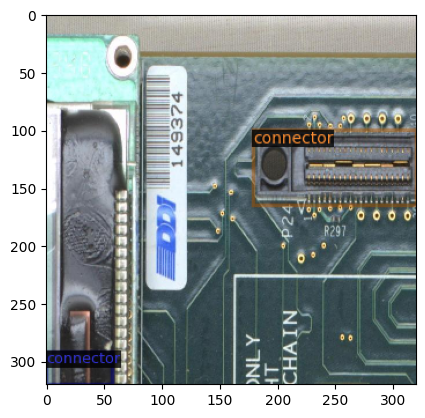

In [ ]:
visualize_data(train_circuit_dicts,circuit_meta)

In [ ]:
# to get list of target classes
target_classes = MetadataCatalog.get("pcb_dataset_train_v3").thing_classes
target_classes

['electronic-components',
 'bead',
 'capacitor',
 'connector',
 'crystal',
 'ic',
 'inductor',
 'led',
 'resistor',
 'semiconductor',
 'switch']

In [ ]:
!pip install wandb
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.6/281.6 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Different models I'd like to try - https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
models_to_try = {
    "R50-FPN-1x": "COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml",
    "R50-FPN-3x": "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
    "R101-FPN-3x": "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml",
    "X101-FPN-3x": "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml",
    "RN-R50-1x": "COCO-Detection/retinanet_R_50_FPN_1x.yaml",
    "RN-R50-3x": "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
    "RN-R101-3x": "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
}

In [ ]:
# set which evaluator you like see detectron2 docs
def get_evaluator(cfg, dataset_name, output_folder=None):
  """
  Create a COCOEvaluator
  """
  if output_folder is None:
    output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
  evaluator = COCOEvaluator(
      dataset_name=dataset_name,
      distributed=False,
      output_dir=output_folder
  )
  return evaluator

In [ ]:
# Create testing function
# using this function to track weights and biases
def do_test(cfg, model):
  results = OrderedDict()
  for dataset_name in cfg.DATASETS.TEST:
    data_loader = build_detection_test_loader(cfg, dataset_name)
    # Get A COCOEvaluator
    evaluator = get_evaluator(
        cfg,
        dataset_name,
        output_folder=os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
    )
    # Make inference on dataset
    # It returns results from Evaluation on dataset
    results_i = inference_on_dataset(model,
                                     data_loader,
                                     evaluator)
    # Update results dictionary
    results[dataset_name] = results_i


    if comm.is_main_process():
      logger.info("Evaluation results for {} in csv format:".format(dataset_name))
      print_csv_format(results_i)

    # Check to see length of results
    if len(results) == 1:
      results = list(results.values())[0]
  
    print("### Saving results to Weights & Biases...")
    wandb.log({"results_dict":results_i})

    return results

In [ ]:
# Create training function
def do_train(cfg, model, resume=False):
  # Set model to training mode
  model.train()
  # Create optimizer from config file 
  optimizer = build_optimizer(cfg, model)
  # Create scheduler for learning rate 
  scheduler = build_lr_scheduler(cfg, optimizer)
  print(f"Scheduler: {scheduler}")

  # Create checkpointer
  checkpointer = DetectionCheckpointer(
      model, save_dir=cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
  )

  start_iter = (
     
      checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, # Use predefined model weights (pretrained model)
                                  resume=resume).get("iteration", -1) + 1
  )
  # Set max number of iterations
  max_iter = cfg.SOLVER.MAX_ITER

  # Create periodiccheckpoint
  periodic_checkpointer = PeriodicCheckpointer(checkpointer=checkpointer,
                                               # How often to make checkpoints?
                                               period=cfg.SOLVER.CHECKPOINT_PERIOD,
                                               max_iter=max_iter)

  # Create writers (for saving checkpoints?)
  writers = (
      [
       # Print out common metrics such as iteration time, ETA, memory, all losses, learning rate
       CommonMetricPrinter(max_iter=max_iter),
       # Write scalars to a JSON file such as loss values, time and more
       JSONWriter(os.path.join(cfg.OUTPUT_DIR, "metrics.json")),
       # Write all scalars such as loss values to a TensorBoard file for easy visualization
       TensorboardXWriter(cfg.OUTPUT_DIR),
      ]
      if comm.is_main_process()
      else []
  )

  
  # Build a training data loader based off the training dataset name in the config
  data_loader = build_detection_train_loader(cfg)

  # Start logging
  logger.info("Starting training from iteration {}".format(start_iter))

  # Store events
  with EventStorage(start_iter) as storage:
    # Loop through zipped data loader and iteration
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
      iteration = iteration + 1
      storage.step() # update stroage with step - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.step

      # Create loss dictionary by trying to model data
      loss_dict = model(data)
      losses = sum(loss_dict.values())
      # Are losses infinite? If so, something is wrong
      assert torch.isfinite(losses).all(), loss_dict
      loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
      # Sum up losses
      losses_reduced = sum(loss for loss in loss_dict_reduced.values())


      # Update storage
      if comm.is_main_process():
        # Store informate in storage - https://detectron2.readthedocs.io/modules/utils.html#detectron2.utils.events.EventStorage.put_scalars
        storage.put_scalars(total_loss=losses_reduced,
                            **loss_dict_reduced)

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()
      # Add learning rate to storage information
      storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
      # This is required for your learning rate to change!!!! (not having this meant my learning rate was staying at 0)
      scheduler.step()

      # Perform evaluation?
      if (
          cfg.TEST.EVAL_PERIOD > 0
          and iteration % cfg.TEST.EVAL_PERIOD == 0
          and iteration != max_iter
      ):
          do_test(cfg, model)
          comm.synchronize()

      # Log different metrics with writers
      if iteration - start_iter > 5 and (iteration % 20 == 0 or iteration == max_iter):
        for writer in writers:
          writer.write()

      # Update the periodic_checkpointer
      periodic_checkpointer.step(iteration)

In [ ]:
# Create setup function
def setup(args):
  """
  Create configs and perform basic setups.
  """
  cfg = get_cfg()
  cfg.merge_from_file(args.config_file) # This will take some kind of model.yaml file
  cfg.merge_from_list(args.opts)
  cfg.freeze()
  default_setup(
      cfg, args
  ) # this logs the config and arguments passed to the command line to the output file

  # Load config YAML as dict
  cfg_yaml = cfg.load_yaml_with_base(os.path.join(cfg.OUTPUT_DIR, "config.yaml"))

  wandb.init(project="pcb_detection",
             sync_tensorboard=True)

  # update the config file after initializing wandb
  wandb.config.update(cfg_yaml)

  return cfg

In [ ]:
# Create main function
def main(args):

  # Create the config file
  cfg = setup(args)

  # Build the model
  model = build_model(cfg)

  logger.info("Model:\n{}".format(model))


  # Only do evaluation if the args say so
  if args.eval_only:
    DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
        cfg.MODEL.WEIGHTS, resume=args.resume
    )
    return do_test(cfg, model)

  # Do distributed training? (depends on number of GPUs available)
  distributed = comm.get_world_size() > 1
  if distributed:
    # Put the model on multiple devices if available
    model = DistributedDataParallel(
        model,
        device_ids=[comm.get_local_rank()],
        broadcast_buffers=False
    )

  # Train the model
  do_train(cfg, model)
  return do_test(cfg, model)

In [ ]:
models_to_try["R101-FPN-3x"]

'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'

In [ ]:
model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl'

In [ ]:
model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

'/content/detectron2/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'

In [ ]:
# Setup arg parser
parser = default_argument_parser()

In [ ]:
# Setup different weights and config files to try
weights = []
configs = []
for k, v in models_to_try.items():
  model = models_to_try[k]
  model_weights = model_zoo.get_checkpoint_url(model)
  weights.append(model_weights)
  config_file = model_zoo.get_config_file(model)
  configs.append(config_file)
weights_configs = dict(zip(weights, configs))
weights_configs

{'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl': '/content/detectron2/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl': '/content/detectron2/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl': '/content/detectron2/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x/139173657/model_final_68b088.pkl': '/content/detectron2/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml',
 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_1x/190397773/model_final_bfca0b.pkl': '/content/de

In [ ]:
# Setup different arg strings to pass to main()
workers = 2
ims_per_batch = 2
lr = 0.0005
max_iter = 3000
seed = 33
num_classes = len(target_classes)

arg_strings = []
for weights, config in weights_configs.items():
  arg_string = f"--config-file {config} \
                MODEL.WEIGHTS {weights} \
                DATASETS.TRAIN ('pcb_dataset_train_v3',) \
                DATASETS.TEST ('pcb_dataset_val_v3',) \
                DATALOADER.NUM_WORKERS {workers} \
                SOLVER.IMS_PER_BATCH {ims_per_batch} \
                SOLVER.BASE_LR {lr} \
                SOLVER.MAX_ITER {max_iter} \
                SEED {seed} \
                MODEL.ROI_HEADS.NUM_CLASSES {num_classes}".split()
  arg_strings.append(arg_string)

In [ ]:
# Create different arg parsers
# only necessary if we are training all the models listed below
# run only one model the run directly
arg_list = []
for arg_string in arg_strings:
  args = parser.parse_args(arg_string)
  print(args)
  arg_list.append(args)

Namespace(config_file='/content/detectron2/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml', resume=False, eval_only=False, num_gpus=1, num_machines=1, machine_rank=0, dist_url='tcp://127.0.0.1:49152', opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_1x/137257794/model_final_b275ba.pkl', 'DATASETS.TRAIN', "('pcb_dataset_train_v3',)", 'DATASETS.TEST', "('pcb_dataset_val_v3',)", 'DATALOADER.NUM_WORKERS', '2', 'SOLVER.IMS_PER_BATCH', '2', 'SOLVER.BASE_LR', '0.0005', 'SOLVER.MAX_ITER', '4000', 'SEED', '33', 'MODEL.ROI_HEADS.NUM_CLASSES', '11'])
Namespace(config_file='/content/detectron2/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml', resume=False, eval_only=False, num_gpus=1, num_machines=1, machine_rank=0, dist_url='tcp://127.0.0.1:49152', opts=['MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl', 'DATASET

In [ ]:
# to train the models sequentially 
for i, namespace in enumerate(arg_list):
  print(f"Running experiment: {1}") # derp......
  main(namespace)

In [ ]:
# get trained config file for predictions
loaded_cfg = get_cfg()
loaded_cfg = loaded_cfg.load_yaml_with_base(os.path.join(loaded_cfg.OUTPUT_DIR, "config.yaml"))
loaded_cfg = detectron2.config.CfgNode(loaded_cfg)

In [ ]:
loaded_cfg["MODEL"]["ROI_HEADS"]["SCORE_THRESH_TEST"]

0.05

In [ ]:
from detectron2.engine import DefaultPredictor
# Setup predictor
loaded_cfg["MODEL"]["WEIGHTS"] = os.path.join(loaded_cfg["OUTPUT_DIR"], "model_final.pth")
loaded_cfg["MODEL"]["ROI_HEADS"]["SCORE_THRESH_TEST"] = 0.5  # set the testing threshold for this model
loaded_cfg["DATASETS"]["TEST"] = ("print_circuit_board_val", )
predictor = DefaultPredictor(loaded_cfg)

[05/21 14:23:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[05/21 14:23:23 fvcore.common.checkpoint]: [Checkpointer] Loading from ./output/model_final.pth ...


WARNING [05/21 14:23:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/21 14:23:52 d2.data.datasets.coco]: Loaded 1235 images in COCO format from /content/pcb-1/valid/_annotations.coco.json
{'instances': Instances(num_instances=7, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[105.2916, 561.6577, 280.3124, 640.0000],
        [246.8471,  26.2499, 596.2609, 264.0630],
        [100.6311,   1.2819, 187.2275,  42.4314],
        [150.2330,  77.7430, 190.6751, 162.2735],
        [ 73.8628,  68.7930, 122.3288, 161.8741],
        [539.4368, 280.9181, 638.2839, 632.5146],
        [235.4195, 322.9448, 300.9319, 391.2316]], device='cuda:0')), scores: tensor([0.8503, 0.8451, 0.8267, 0.7923, 0.7895, 0.7083, 0.5513],
       device='cuda:0'), pred_classes: tensor([5, 5, 8, 8, 8, 3, 5], device='cuda:0')])}


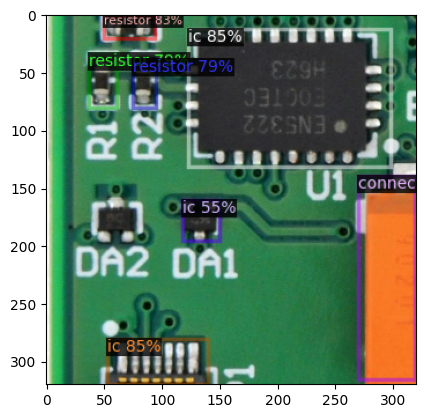

In [ ]:
#circuits data dictionaries
val_circuit_dicts = DatasetCatalog.get("pcb_dataset_val_v3")
# dataset metadata
val_circuit_meta = MetadataCatalog.get("pcb_dataset_val_v3")
for d in random.sample(val_circuit_dicts, 1):
  img = cv2.imread(d["file_name"])
  outputs = predictor(img)
  print(outputs)
  visualizer = Visualizer(img[:, :, ::-1], metadata=val_circuit_meta, scale=0.5)
  out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
  # check for detectron2 docs how to get image from visualizer VisImage.get_image()
  plt.imshow(out.get_image())

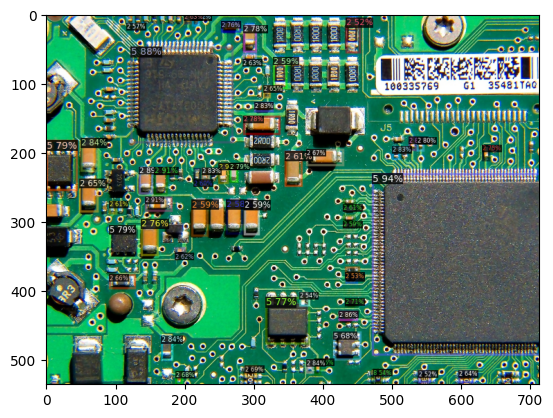

In [ ]:
im = cv2.imread("/content/a-circuit-board-description-automatically-generat.jpeg")
outputs = predictor(im)
visualizer = Visualizer(im[:, :, ::-1], scale=0.5)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
# check for detectron2 docs how to get image from visualizer VisImage.get_image()
plt.imshow(out.get_image())

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!zip -r /content/output.zip /content/output

  adding: content/output/ (stored 0%)
  adding: content/output/events.out.tfevents.1716300183.20c9a2df85a9.582.0 (deflated 73%)
  adding: content/output/model_final.pth (deflated 7%)
  adding: content/output/log.txt (deflated 87%)
  adding: content/output/metrics.json (deflated 80%)
  adding: content/output/config.yaml (deflated 64%)
  adding: content/output/inference/ (stored 0%)
  adding: content/output/inference/pcb_dataset_val_v3/ (stored 0%)
  adding: content/output/inference/pcb_dataset_val_v3/coco_instances_results.json (deflated 72%)
  adding: content/output/inference/pcb_dataset_val_v3/instances_predictions.pth (deflated 61%)
  adding: content/output/last_checkpoint (stored 0%)


In [ ]:
from google.colab import files
files.download("/content/output.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>